# Autoencoder example

In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# A basic encoder/decoder with a single internal layer
# Allows for augmentation of the encoder, i.e. if we have already extracted some information from the data and want to use it in the encoding, it can be concatenated to it.
class EncoderDecoder(nn.Module):
    def __init__(self, in_size, out_size, mid_size, aug_size = 0):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_size, mid_size), nn.ReLU(), nn.Linear(mid_size, out_size))
        self.dec = nn.Sequential(nn.Linear(out_size + aug_size, mid_size), nn.ReLU(), nn.Linear(mid_size, in_size))
        self.aug_size = aug_size

    def forward(self, x, a = None):
        return self.decode(self.encode(x, a))
    
    def encode(self, x, a = None):
        if a == None:
            a = torch.zeros((x.shape[0], self.aug_size))
        return torch.cat([self.enc(x), a], dim=1)
    
    def decode(self, x):
        return self.dec(x)


### Encoders should be able to extract the period

Suppose the data always looks like a periodic blips of $1$'s and $0$'s otherwise with period $2^i$, plus some small noise.

In [14]:
k = 8

# The data will just be periodic blips where the period is a power of 2 plus some noise
base_data = torch.zeros((k+1, 2 ** k))
for i in range(0, k+1):
    base_data[i, 0::2**i] = 1

# Generate the data
def generate_data(n: int):
    return base_data[torch.randint(0, k+1, size=(n,))] + torch.randn(size=(n, 2**k))*0.1


Train 4000 iterations with batch size 1024.

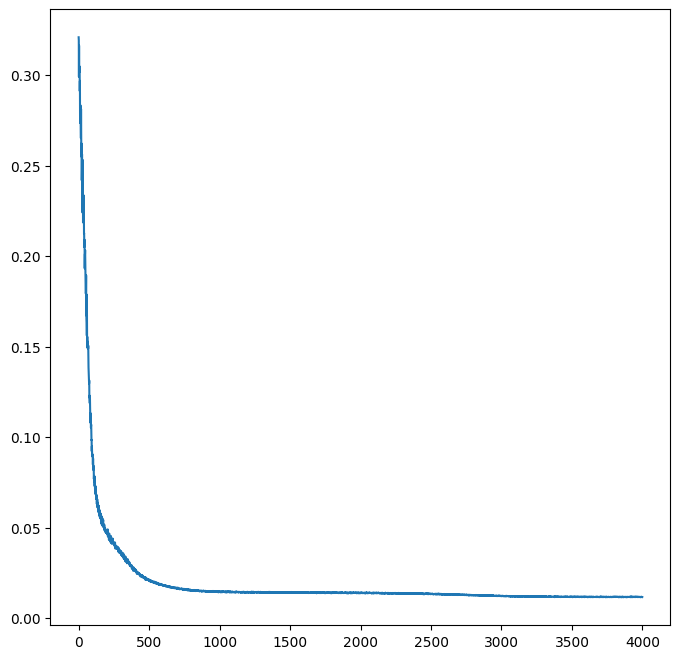

In [42]:

m = EncoderDecoder(2**k, 1, 16)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
losses = []

for i in range(4000):
    X = generate_data(1024)
    y = X.detach().clone()
    u = m.forward(X)
    loss = loss_fn(u, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())



plt.figure(figsize=(8,8))
plt.plot(range(len(losses)), losses)


With noiseless data, loss should be low.

In [19]:

e = m.encode(base_data)
d = m.decode(e)

print(f"Loss on base data: {loss_fn(d, base_data)}")

print(f"base data encodings: \n{e}")

Loss on base data: 0.0018326672725379467


### Encoders shouldn't be able to compress 256 dimensions into 1

One can try training it on random data.  We expect no convergence, i.e. it shouldn't be possible to encode 256-dimensional data in 1-dimensional data.

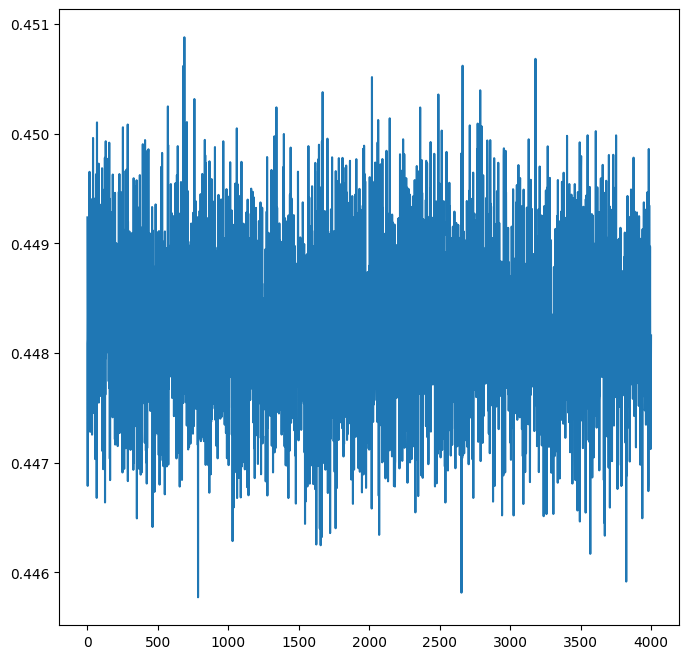

In [43]:

m2 = EncoderDecoder(2**k, 1, 16)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
losses = []

for i in range(4000):
    X = torch.rand((1024, 2**k))
    y = X.detach().clone()
    u = m2.forward(X)
    loss = loss_fn(u, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())



plt.figure(figsize=(8,8))
plt.plot(range(len(losses)), losses)


### Augmenting the encoder

Suppose we are in a situation where we have an embedding of the data we already want to use.  We can use autoencoder to detect it.  We augment the encoder with the known log period, reduce the encoding dimension to 0 (not including the augmentation), and see if the decoder can figure it.

In [31]:
log_base_targets = torch.arange(k+1)[:, None]
base_targets = 2 ** torch.arange(k+1)[:, None]


def generate_data_targets(n: int):
    r = torch.randint(0, k+1, size=(n,))
    return base_data[r] + torch.randn(size=(n, 2**k))*0.1, log_base_targets[r], base_targets[r]

/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


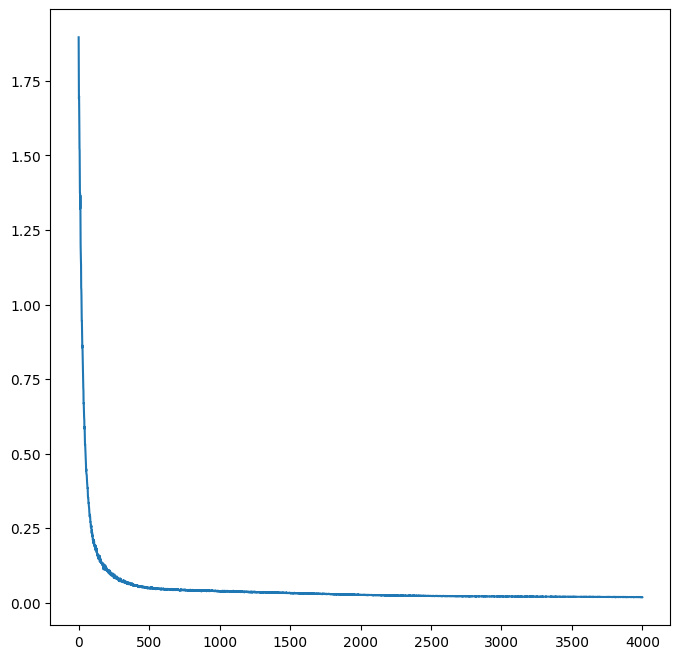

In [44]:

m = EncoderDecoder(2**k, 0, 16, 1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
losses = []

for i in range(4000):
    X, a, _ = generate_data_targets(1024)
    y = X.detach().clone()
    u = m.forward(X, a)
    loss = loss_fn(u, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())



plt.figure(figsize=(8,8))
plt.plot(range(len(losses)), losses)


In [41]:

e = m.encode(base_data, log_base_targets)
d = m.decode(e)

print(f"Loss on base data: {loss_fn(d, base_data)}")

print(f"base data encodings: \n{e}")

print(d[1])

Loss on base data: 0.007608965039253235
base data encodings: 
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.]], grad_fn=<CatBackward0>)
tensor([0.9725, 0.0436, 0.9667, 0.0349, 1.0559, 0.0256, 0.9183, 0.0307, 1.0337,
        0.0159, 0.9797, 0.0357, 1.0354, 0.0229, 0.9252, 0.0476, 1.0043, 0.0620,
        0.9260, 0.0246, 1.0513, 0.0373, 0.8852, 0.0471, 1.0186, 0.0315, 0.9907,
        0.0320, 1.0689, 0.0263, 0.9514, 0.0426, 0.9768, 0.0426, 0.9707, 0.0293,
        1.0254, 0.0680, 1.0000, 0.0664, 1.0387, 0.0253, 0.9495, 0.0335, 1.0286,
        0.0518, 0.9323, 0.0153, 0.9975, 0.0267, 0.9361, 0.0398, 1.0623, 0.0287,
        0.9731, 0.0431, 1.0233, 0.0374, 0.9011, 0.0417, 1.0280, 0.0359, 0.9881,
        0.0259, 0.9418, 0.0244, 0.9812, 0.0374, 1.0485, 0.0386, 0.9790, 0.0383,
        1.0253, 0.0299, 0.9982, 0.0297, 1.0567, 0.0417, 0.9799, 0.0343, 1.0128,
        0.0233, 0.9040, 0.0109, 1.0479, 0.0639, 0.9806, 0.0444, 1.0

# Some PCA

Try running PCA on the periodic blips data and see what it does.  Expectation: it will still see many axes with high correlations.  The reason is that the relationship between the data entries is not linear, and PCA detects colinearity.

In [9]:
import sklearn
import scipy

X = base_data.numpy()
y = np.arange(9)
# Centered X
X0 = X - X.mean(axis=0)
y0 = y - y.mean(axis=0)

svd = scipy.sparse.linalg.svds(X0)
print(f"singular values: {svd[1]}")

singular values: [ 1.6096594  2.3904438  3.494739   5.068038   7.6252565 15.387929 ]


In [10]:
import sklearn.decomposition

print(X.shape)
pca = sklearn.decomposition.PCA(3)
pca.fit(X)
print(pca.singular_values_)
print(pca.components_.shape)


(9, 256)
[15.387925   7.6252575  5.068036 ]
(3, 256)


In [11]:
lr = sklearn.linear_model.LinearRegression(fit_intercept=False)

X_red = pca.transform(X0)

lr.fit(X_red, y0)

print(lr.coef_)

print(lr.predict(X_red) + y.mean(axis=0))
print(y)

[-0.27005538 -0.10704301 -0.00508458]
[2.26415706 3.15403521 4.50238895 5.4413625  5.92368233 6.13514113
 6.21760678 6.24552655 6.25254297]
[0 1 2 3 4 5 6 7 8]
